## Task List

Что нужно:
- Найти датасет (конфигурируется с помощью камеры)
- Посмотреть, как определять с помощью tesseract текст (детектить и обрезать) - отобразить
- Попробовать это закастомить
- Проверить коробочные метрики teseract
- Продумать пайплайн (перевести в ЧБ)

Наверное, если успеется:
- Попробовать закастомить tesseract
- Скачать с помощью keras MNASNET
- обучить посмотреть метрики
- Посмотреть скорость распознования на потоке картинок отдельно для tesseract и отдельно для MNASNET

Класс задач - компьютерное зрение. 
Пожелания: 
Разработка единого, кросс-платформенного решения на основе java с возможностью переноса на платформу ios, Android. 
Заказчик:
Своя тема
Итоговое тема: 
На согласовании.

Этап нулевой:
Поставить все на комп. 
Для V8 не нужен gcc, используем легче решение: https://github.com/sqreen/PyMiniRacer
Непонятно, что с npm, но пока опустим - не до красоты.
 
Этап первый: 
Распознанный текст на керрасе запихать в док. 
Повторить штуку на вебке с использованием Java или захерачить на андроид. Подумать/посмотреть и, возможно, сделать все таки универсально - то есть для всего, куда можно засунуть keras.
-- Как выяснилось, почти везде есть V8 и eval() (даже в ios(!)) соответственно цель - запилить общую скрипт-ориентированную логику для обработки аццких данных с тессеракта.
 
Этап второй: 
Создать логику эволюции документа с дописыванием оригинала. Это уже на джаве.
Запилить более-менее работающее нечто на java. Посмотреть, что там по кросс платформенному. Прод-сборка.

Этап третий: 
Обучение модели на картинках. Теория почерков и теория контекстов. Упоротость в нуль и полет в космос на weblogic.

![alt text](test.png)

![alt text](test_real.jpg)

In [17]:
import PIL
import pytesseract
import cv2
import numpy as np
from matplotlib import pyplot as plt
import re
import json
from py_mini_racer import py_mini_racer
from IPython.core.display import display, HTML

def print_img (crimg):
    plt.imshow(crimg)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

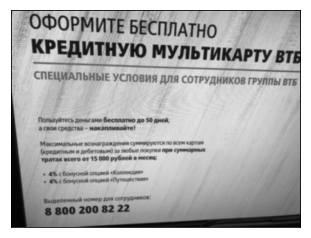

In [3]:
img_cl = cv2.imread(r'test_real.jpg',0)
img = cv2.cvtColor(img_cl, cv2.COLOR_GRAY2RGB) #numpy array
# plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.imshow(img, interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

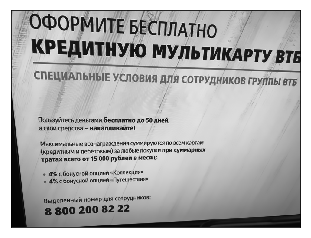

In [4]:
img_demoise = cv2.fastNlMeansDenoising(img,None,10,7,21)
print_img(img_demoise)

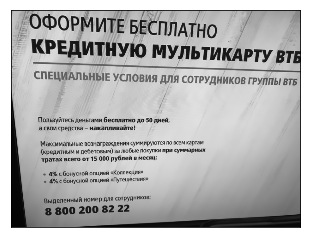

In [21]:
# Вот здесь нужно поиграться еще и понять - надо вообще ли уменьшать и как быть с этой штукой?
img_small = cv2.resize(img, (0,0), fx=0.95, fy=0.95)
print_img(img_small)

Если уменьшить размер в 2 раза, то он текста не видит..

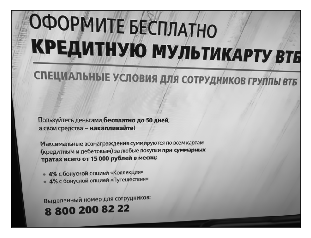

In [6]:
img_demoise = cv2.fastNlMeansDenoising(img_small,None,10,7,21)
print_img(img_demoise)

In [7]:
img = img_demoise

Идея, чтобы народ не мучать - автоматом cropить изображение до миимального распознанного текста и супер быстро искать слово по англ и рус словарю - делать это в цикле с ходом по x и y

In [8]:
# для уменьшения размера - потом додумать
# small = cv2.resize(image, (0,0), fx=0.5, fy=0.5) 
# resized_image = cv2.resize(image, (100, 50)) 

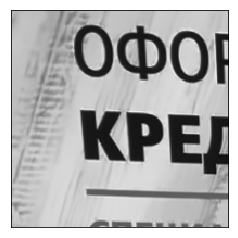

офог
кре;


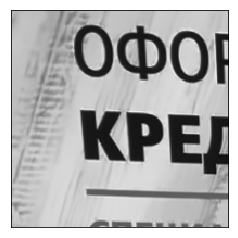

O(DOF
KPE;


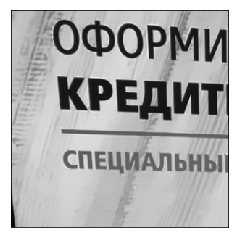

‚ "ОФОРМИ
КРЕДИТ!

СПЕЦИАЛЬНЫ!


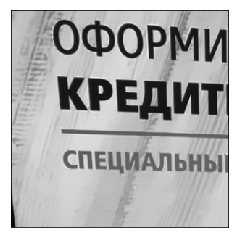

, "O(DOPMVI
KPEDMTI

CHEuVIAﬂbeII


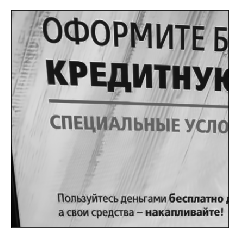

‚"ОФОРМИТЕ Б
КРЕДИТНУП

СПЕЦИАЛЬНЫЕ УСЛО

 

Пользуйтесь деньгами бесплато :
а свои средства — иакаппивайю!


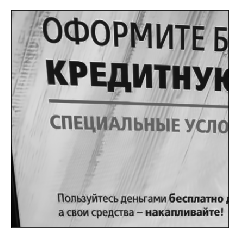

{0(DOPMVITE 5
KPEDMTHVH

CHElU/lAﬂbelE YUIO

 

ﬂonuymea: neHuraMm Secnnamo 1
a cam cpencraa ~ uaxannuaav‘ne!


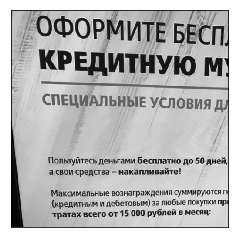

‚Ё'ОФОРМИТЕ ведёт
кредитную мъ

СПЕЦИАЛЬНЫЕ УСЛОВИЯ д!

 

Пользуйтесь деньгами бесплато до 50 дней,
а свои средства — иакаппивайте!

Максимальные вознаграждения суммируются пк
(крепишым и дебетовым) за любые покупки пр:
тратах всего от 15 000 рублей в месяц:


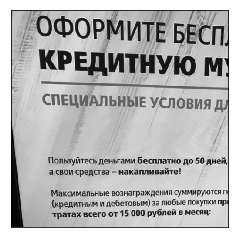

,f'ocbopMI/ITE 55%}
KPEDMTHVIO M!

CI'IElU/IAHbelE YCJIOBVIH ﬂ!

 

ﬂonwyﬁ'recb ﬂeHN’aMM Secnnamo no 50 nHeFI,
a CEO“ cpenaaa ~ uaxannuaav‘ne!

MaxchaanbIe aoaHarpaxneum cyMMMpymcn m
(erﬂanbIM M neﬁewabm) 3a moéme rloKynKH up:
warax ncero or 15 000 py6nev'l a Mecnu:


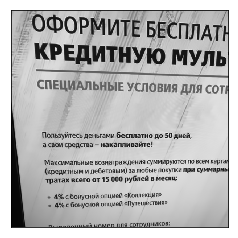

‚ЁОФОРМИТЕ №№;
к"Едитную мулн

СПЕЦИАЛЬНЫЕ УСЛОВИЯ дЛЯ СОТР

 

Пользуйтесь деньгами бесплато до 50 дней,
а свои средства — иакаппивайте!

Максимальные вознаграждения суммируются по всем карт
(крепишым и дебетовым) за любые покупки при суимариы
тратах всего от 15 000 рублей в месяц:

. 4% ‹ бонусной опцией иКоппекция»
- 1% сбоиукиой опцией «Путешепвия»

.…..мй нпмвп пля сотудиИКОБЭ


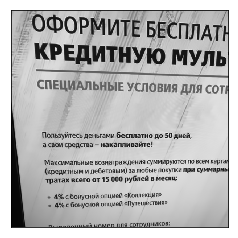

,FOCDOPMMTE 5é%nnAT;
KPEDMTHVIO mynb'

CI'IElU/IAIlebIE YCJIOBVIH mm COTF

 

ﬂonwyﬁ'recb ﬂeHN’aMM Secnnamo no 50 AHeFI,
a caom cpencraa ~ uaxannuaav‘ne!

MaKCMMaﬂbele aoaHarpaxneum cyMMMpymcn no EteM Kaprar
(ernanbIM M neﬁewabm) 3a moﬁme noxynxm npu cynnapuu
warax ncero or 15 000 py6nev'l a Menu:

. 4% c 60Hycuol71 enumeﬁ «Konnexuma»
- 5% céouymoil onumeil ul'lytewecravm»

muun unuﬂn nun comvnnleon:


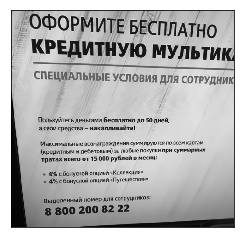

СПЕЦИАЛЬНЫЕ УСЛОВИЯ ДЛЯ СОТРУДНИК

Пользуйтесь деныами бесплатно по 50 дней,
а свои средства * иакаппивайте!

Максимальные вознаграждения (уммируются по всем карти
(кредитным и дебетовым) за любые покупки при суммарных

трачах всего 01 15 000 рублей в месяц:

- 4% сбонусиой опцией «Коллекция»
- 4% сбонукной опцией «Путешеавия»

Выделенный номер для сотрудников:

8 80° 20° 82 22
4


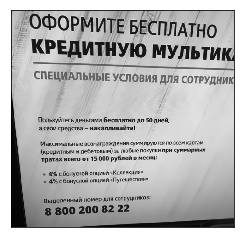

CHELMN'IbeIE YCHOBMH mm COTPYJIHMK

l'lonhzyﬁ'recb neHM’aMm 6e<nnamo no 50 Mei,
a cam cpencraa 7 uaxannuaav‘ne!

MaKCMMaIIbeIE BOSHaI’anAeHMR (YMMMPYMJYUI no aceM xapraM
(erﬂlﬂTthM m neéeTOBblM) 3a maﬁbre noxynm npu cyMMapuux

rpavax stem 01 15 000 py6nev'l a menu:

- 4% cﬁoHycHoﬂ onumeﬁ «Konnekum»
- A‘x (Gouymoﬁ onunelil ul'lytemecmvm»

Bblnenennbm HoMep nun corpynumkoa:

8 800 200 82 22
4


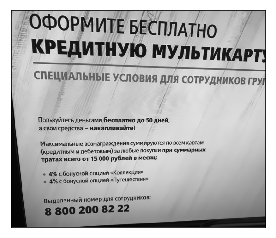

/

оформите вё‘сплмйо ’
крвдитную мультикдрп
\

СПЕЦИАЛЬНЫЕ УСЛОВИЯ ДЛЯ СОТРУДНИКОВ ГРУП

Пользуйтесь деныами бесплатно по 50 дней,
а свои средства * иакаппивайте!

Максимальные вознаграждения (уммируются по всем карти
(кредитным и дебетовым) за любые покупки при суммарных

трачах всего 01 15 000 рублей в месяц:

- 4% сбонусиой опцией «Коллекция»
- 4% сбонукной опцией «Путешеавия»

Выделенный номер для сотрудников:
8 800 200 82 22

4—


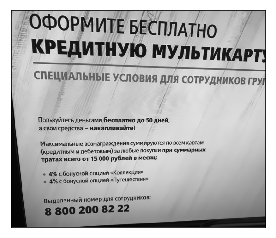

/

0<DOPMVITE B/é’Cl'lﬂATi/LIO ’
KPEﬂI/ITHVIO MYJ’leMKAPT!
\

CHEUMAJ'IbeIE YCﬂOBMﬂ mm COTPYJIHMKOB rPYE

l'lonhzyﬁ'recb neHM’aMm 6e<nnamo no 50 Mei,
a cam cpencraa 7 uaxannuaav‘ne!

MaKCMMaIIbeIE BOSHaI’anAeHMR (YMMMPYMJYUI no aceM xapraM
(erﬂlﬂTthM m neéeTOBblM) 3a maﬁbre noxynm npu cyMMapuux

rpavax stem 01 15 000 py6nev'l a menu:

- 4% cﬁoHycHoﬂ onumeﬁ «Konnekum»
- A‘x (Gouymoﬁ onunelil ul'lytemecmvm»

Bblnenennbm HoMep nun corpynumkoa:
8 800 200 82 22

44


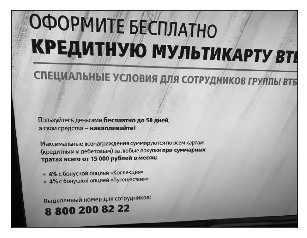

/

оформите вёёплмйо
кредитную мультикдрту вп

СПЕЦИАЛЬНЫЕ УСЛОВИЯ ДЛЯ СОТРУДНИКОВ ГРУППЫ ВТБ

Пользуйтесь деныами бесплатно по 50 дней,
а свои средства * иакаппивайте!

Максимальные вознаграждения (уммируются по всем карти
(кредитным и дебетовым) за любые покупки при суммарных
трачах всего 01 15 000 рублей в месяц:

- 4% сбонусиой опцией «Коллекция»
- 4% сбонукной опцией «Путешеавия»

Выделенный номер для сотрудников:
8 800 200 82 22 '


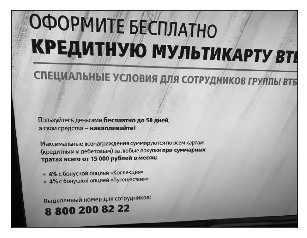

/

0<DOPMVITE s/éknnArho
KPEDMTHVIO ManTMKAPTY m

CHEUMAJ'IbeIE YCIIOBMH LUIS! COTPYJIHMKOB l'PYI'IHbI 8T5

l'lonhzyﬁ'recb neHM’aMm 6e<nnamo no 50 Mei,
a cam cpencraa 7 uaxannuaav‘ne!

MaKCMMaIIbeIE BOSHaI’anAeHMR (YMMMPYMJYUI no aceM xapraM
(erﬂlﬂTthM m neéeTOBblM) 3a maﬁme noxynm npu cyMMapuux
rpavax stem 01 15 000 py6nev'l a menu:

- 4% cﬁoHycHoﬂ onumeﬁ «Konnekum»
- A‘x (Gouymoﬁ onunelil ul'lytemecmvm»

Bblnenennbm HoMep nun corpynumkoa:
8 800 200 82 22 I


In [9]:
crop_img = img
for i in range(10):
#     for j in range(10):
    crop_img = img[0:(i*100+1), 0:(i*100+1)]
    str_res = pytesseract.image_to_string(crop_img, lang="rus")
    if (len(str_res)>6):
        print_img(crop_img)
        print(str_res)
    str_resen = pytesseract.image_to_string(crop_img, lang="eng")
    if (len(str_resen)>6):
        print_img(crop_img)
        print(str_resen)
        
# Здесь для определения языка нужно дополнитеьно сверять слова со словарем каждого. 
# А для этого нужен ловарь всех слов всех, мать их, языков (нужно думать)
# Самое простое - определять сначала по regexp к какому классу ascii оно пренадлежит и потом смотреть на словарь

# при этом отслеживать количество "годных" слов и смотреть их общий процент в отображенном куске

# import re
# regex = re.compile("[А-Яа-я:=!\)\()A-z\_\%/|]+")

# def words_only(text, regex=regex):
#     try:
#         return " ".join(regex.findall(text))
#     except:
#         return ""



# def lemmatize(text, mystem=m):
#     try:
#         return "".join(m.lemmatize(text)).strip()  
#     except:
#         return " "

#### Итог: нужно уменьшать картинку - теряем в мощности. Плюс надо картинку в ЧБ перевести. Тогда пробегать будем намного быстрее. Легче дописывать документ на более близком расстоянии, чем заниматься фигней.

In [10]:
%%time
print(pytesseract.image_to_string(img, lang="rus"))
# OR explicit beforehand converting
# print(pytesseract.image_to_string(Image.fromarray(img))

/

оформите вёёплмйо
кредитную мультикдрту втв

СПЕЦИАЛЬНЫЕ УСЛОВИЯ ДЛЯ СОТРУДНИКОВ ГРУППЫ ВТБ

Пользуйтесь деныами бесплатно по 50 дней,
а свои средства * иакаппивайте!

Максимальные вознаграждения (уммируются по всем карти
(кредитным и дебетовым) за любые покупки при суммарных
трачах всего 01 15 000 рублей в месяц:

- 4% сбонусиой опцией «Коллекция»
- 4% сбонукной опцией «Путешеавия»

Выделенный номер для сотрудников:
8 800 200 82 22 .
CPU times: user 154 ms, sys: 11.7 ms, total: 166 ms
Wall time: 3.11 s


In [11]:
img.size

1869372

In [12]:
print(pytesseract.image_to_data(img, lang="rus"))

level	page_num	block_num	par_num	line_num	word_num	left	top	width	height	conf	text
1	1	0	0	0	0	0	0	911	684	-1	
2	1	1	0	0	0	754	0	6	12	-1	
3	1	1	1	0	0	754	0	6	12	-1	
4	1	1	1	1	0	754	0	6	12	-1	
5	1	1	1	1	1	754	0	6	12	87	/
2	1	2	0	0	0	58	0	853	171	-1	
3	1	2	1	0	0	58	0	853	171	-1	
4	1	2	1	1	0	58	0	588	92	-1	
5	1	2	1	1	1	58	15	298	62	72	оформите
5	1	2	1	1	2	374	0	272	92	53	вёёплмйо
4	1	2	1	2	0	64	93	847	78	-1	
5	1	2	1	2	1	64	93	361	61	70	кредитную
5	1	2	1	2	2	444	111	378	57	79	мультикдрту
5	1	2	1	2	3	831	129	80	42	80	втв
2	1	3	0	0	0	73	196	826	44	-1	
3	1	3	1	0	0	73	196	826	44	-1	
4	1	3	1	1	0	73	196	826	44	-1	
5	1	3	1	1	1	73	196	237	31	85	СПЕЦИАЛЬНЫЕ
5	1	3	1	1	2	320	203	139	27	89	УСЛОВИЯ
5	1	3	1	1	3	468	208	58	28	89	ДЛЯ
5	1	3	1	1	4	537	210	199	29	88	СОТРУДНИКОВ
5	1	3	1	1	5	745	216	102	23	94	ГРУППЫ
5	1	3	1	1	6	854	219	45	21	88	ВТБ
2	1	4	0	0	0	86	339	411	46	-1	
3	1	4	1	0	0	86	339	411	46	-1	
4	1	4	1	1	0	86	339	411	21	-1	
5	1	4	1	1	1	86	339	111	21	71	Пользуйтесь
5	1	4	1	1	2	202	344	83	14	75	дены

In [13]:

# Здесь доработать функцию, которая будет искать слова по словарю определенного языка и валидировать их
def image_to_json(input_img, lang=''):
    json_obj = []
    itd_str = ''
    if (lang!=''):
        itd_str = pytesseract.image_to_data(input_img, lang=lang)
    else:
        itd_str = pytesseract.image_to_data(input_img)
    rows_strs = itd_str.split('\n')
    headers = rows_strs[0].split('\t') 
    rows = rows_strs[1:]
    for i in range(len(rows)):
        cur_obj = {}
        cols = rows[i].split('\t')
        for h in range(len(headers)):
            # вот здесь должна быть валидация!!!!!!
            if(h < len(cols)):
                cur_obj[headers[h]] = cols[h]
            else:
                cur_obj[headers[h]] = ''
        json_obj.append(cur_obj)
#     print(json_obj)
    json_norm = to_rows_normalization(json_obj)
    json_str = json.dumps(json_norm)
    return json_str

# Функция, которая должна пробегаться по всем словам, смотреть их расположение и записывать в одну строку
# условием является то, что, если 2 элемента перекрываются по top или top+width
def to_rows_normalization(obj):
    norm_obj = []
    # предположим, что первый элемент - первая строка
    first = {}
    objs_len = len(obj)
    ind = 0
    while ind < objs_len:
        if (len(obj[ind]["text"])>0):
            first = obj[ind]
            ind = objs_len
        ind = ind + 1
    norm_obj.append({"elems":[],"height":first["height"],"top":first["top"], "left":"0"})
    for i in range(objs_len): 
        print(str(i)+' of '+str(len(obj))+' total rows: '+str(len(norm_obj)))
        t2 = int(obj[i]["top"])
        h2 = int(obj[i]["height"])
        w2 = int(obj[i]["width"])
        print(obj[i]["height"]+str(h2))
        if (h2>0 and w2>0 and len(obj[i]["text"])>0):
            j = 0
            new_flg = 1
            while j < len(norm_obj):
                t1 = int(norm_obj[j]["top"])
                h1 = int(norm_obj[j]["height"])
                add_flg = 0
                print('   '+norm_obj[j]["top"]+' < '+str(t2+h2)+' && '+norm_obj[j]["top"]+' > '+str(t2+h2))
                print('   '+str(t2)+' < '+str(t1+h1)+' && '+str(t2+h2)+' > '+str(t1+h1))
                if (t1<t2+h2 and t1+h1>t2+h2):
                    add_flg = 1
                elif (t2<t1+h1 and t2+h2>t1+h1):
                    add_flg = 1
                if (add_flg==1):
                    norm_obj[j]["elems"].append(obj[i])
                    print('   added')
                    new_flg = 0
                    if(h2>h1):
                        norm_obj[j]["height"] = str(h2)
                    j = len(norm_obj)
                j = j+1
            if (new_flg==1):
                norm_obj.append({"elems":[obj[i]],"height":obj[i]["height"],"top":obj[i]["top"], "left":obj[i]["left"]})
                print('   new row')
    return norm_obj

# Нужна еще функция, которая будет приводить строки в нормальный вид - вычислять по среднему размер тескта, отступы
# Плюс сортировку сторк по top - для человеческого рендеринга
# Дополнительно - доопределение слов из текста (если выйдет)
def rows_sort_and_validate(rows):
    grows = []
    return grows

Так, понимать тессеракт научились. Теперь зажбарим это все в файл и херакнем по нему JS на конфиг html (для начала)
Дальше проблема заключается в том, что нужно отслеживать состояние документа и сравнивать старое и новое. 

Обрабатываем все это в JS (эмулируя какую-либо платформу/браузер - используем движок V8 от mozilla)

https://github.com/sqreen/PyMiniRacer

In [19]:
%%time
json_py_str = image_to_json(img, "rus")
ctx = py_mini_racer.MiniRacer()
ctx.eval("""
function start(JSONstr) {
    var doc = new json_to_html();
    doc._init(JSONstr);
    return doc.toHtml();
};
function json_to_html(json) {
    this._obj = null;
    this._init = function(json_str) {
        this._obj = JSON.parse(json_str);
    }
    this.toHtml = function() {
        var cur = this._obj;
        var res_str = '<html><head></head><body style="background:#e0e0e0;">';
        for(var i = 0;i<cur.length;i++) {
            res_str += '<div style="position:absolute;background:#FFF;'+
            'top:'+cur[i].top+'px;'+
            'height:'+cur[i].height+'px;">';
            for (var ie = 0;ie < cur[i].elems.length;ie++) {
                res_str += '<span style="position:absolute;left:'+cur[i].elems[ie].left+'px;'+
                'width:'+cur[i].elems[ie].width+'px;'+
                'height:'+cur[i].elems[ie].height+'px;font-size:'+cur[i].elems[ie].height+'px;">'+
                //здесь пока поставлен font-size на конкретный элемент - в будующем - на всю строку
                cur[i].elems[ie].text+'</span>';
            }
            res_str += '</div>';
        }
        res_str += '</body></html>';
        return res_str;
    }
};
""")
result_doc = ctx.call("start",json_py_str)
text_file = open("Output.html", "w")
text_file.write(result_doc)
text_file.close()
print(result_doc)

0 of 93 total rows: 1
684684
1 of 93 total rows: 1
1212
2 of 93 total rows: 1
1212
3 of 93 total rows: 1
1212
4 of 93 total rows: 1
1212
   0 < 12 && 0 > 12
   0 < 12 && 12 > 12
   new row
5 of 93 total rows: 2
171171
6 of 93 total rows: 2
171171
7 of 93 total rows: 2
9292
8 of 93 total rows: 2
6262
   0 < 77 && 0 > 77
   15 < 12 && 77 > 12
   0 < 77 && 0 > 77
   15 < 12 && 77 > 12
   new row
9 of 93 total rows: 3
9292
   0 < 92 && 0 > 92
   0 < 12 && 92 > 12
   added
10 of 93 total rows: 3
7878
11 of 93 total rows: 3
6161
   0 < 154 && 0 > 154
   93 < 92 && 154 > 92
   0 < 154 && 0 > 154
   93 < 12 && 154 > 12
   15 < 154 && 15 > 154
   93 < 77 && 154 > 77
   new row
12 of 93 total rows: 4
5757
   0 < 168 && 0 > 168
   111 < 92 && 168 > 92
   0 < 168 && 0 > 168
   111 < 12 && 168 > 12
   15 < 168 && 15 > 168
   111 < 77 && 168 > 77
   93 < 168 && 93 > 168
   111 < 154 && 168 > 154
   added
13 of 93 total rows: 4
4242
   0 < 171 && 0 > 171
   129 < 92 && 171 > 92
   0 < 171 && 0 > 171


   615 < 360 && 639 > 360
   370 < 639 && 370 > 639
   615 < 386 && 639 > 386
   370 < 639 && 370 > 639
   615 < 381 && 639 > 381
   416 < 639 && 416 > 639
   615 < 432 && 639 > 432
   439 < 639 && 439 > 639
   615 < 459 && 639 > 459
   467 < 639 && 467 > 639
   615 < 486 && 639 > 486
   517 < 639 && 517 > 639
   615 < 535 && 639 > 535
   540 < 639 && 540 > 639
   615 < 545 && 639 > 545
   591 < 639 && 591 > 639
   615 < 611 && 639 > 611
   624 < 639 && 624 > 639
   615 < 650 && 639 > 650
   added
91 of 93 total rows: 15
2424
   0 < 637 && 0 > 637
   613 < 92 && 637 > 92
   0 < 637 && 0 > 637
   613 < 12 && 637 > 12
   15 < 637 && 15 > 637
   613 < 77 && 637 > 77
   93 < 637 && 93 > 637
   613 < 154 && 637 > 154
   196 < 637 && 196 > 637
   613 < 227 && 637 > 227
   339 < 637 && 339 > 637
   613 < 360 && 637 > 360
   370 < 637 && 370 > 637
   613 < 386 && 637 > 386
   370 < 637 && 370 > 637
   613 < 381 && 637 > 381
   416 < 637 && 416 > 637
   613 < 432 && 637 > 432
   439 < 637 && 43

In [20]:
display(HTML('<iframe id="FileFrame" src="about:blank" width="800" height="400"></iframe>'+
'<script type="text/javascript">'+
'var doc = document.getElementById(\'FileFrame\').contentWindow.document;'+
'doc.open();'+
'doc.write("'+result_doc.replace("\"",'\\"')+'");'+
'doc.close();'+
'</script>'))

Здесь просто невыполняемый текст функции с подсветкой для удобства

In [254]:
%%javascript
function start(JSONstr) {
    var doc = new json_to_html();
    doc._init(JSONstr);
    return doc.toHtml();
};
function json_to_html(json) {
    this._obj = null;
    this._init = function(json_str) {
        this._obj = JSON.parse(json_str);
    }
    this.toHtml = function() {
        var cur = this._obj;
        var res_str = '<html><head></head><body style="background:#e0e0e0;">';
        for(var i = 0;i<cur.length;i++) {
            res_str += '<div style="position:absolute;backgorund:#FFF;'+
            'top:'+cur[i].top+'px;left:'+cur[i].left+'px;width:'+cur[i].width+'px;'+
            'height:'+cur[i].height+'px;font-size:'+cur[i].height+'px;">'+cur[i].text+'</div>';
        }
        res_str += '</body></html>';
        return res_str;
    }
};

<IPython.core.display.Javascript object>

Дальше - у документа есть эти модули со словами - нужно назначить им уникальные ID на основании расположения и ID слова - тогда можно будет сделать "эволюцию" документа. То есть каждое последующее отображение дока будет улучшать предыдущее. И более того - расширять документ.

При этом поиск элемента в текущем доке можно устроить как прямой, так и по семантике, типа data-аттрибутов и просто тупого text по indexOf